In [49]:
#Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.regularizers import l2 ##to prevent overfitting
# from sklearn.preprocessing import RobustScaler


In [47]:
#setting seed for reproducibility (Keras, 2025)
SEED = 44
# random.seed(SEED)
# np.random.seed(SEED)
# tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)

In [35]:
#Loading data
sb_df = pd.read_csv("/content/starbucks_open_7year - starbucks_open_7year.csv.csv")
sb_df["Date"] = pd.to_datetime(sb_df["Date"]) #(Joseph, 2022)
sb_df = sb_df.set_index("Date").sort_index() #sorting by date
sb_df["Log_Open"] = np.log(sb_df["Open"]) #(Numpy, 2024) Log transformation as stock prices exhibit exponential growth (Fama, 1965)- this is better for real word problems and will help in improving accuracy when evaluating actual prices
data = sb_df["Log_Open"]
# data = sb_df[["Open"]].values
sb_df.head()

,Unnamed: 0,Open,Time,Log_Open
Date,,,,
2017-11-13,0,56.81,1510531200,4.039712
2017-11-14,1,56.47,1510617600,4.033710
2017-11-15,2,56.82,1510704000,4.039888
2017-11-16,3,56.92,1510790400,4.041647
2017-11-17,4,57.24,1510876800,4.047253


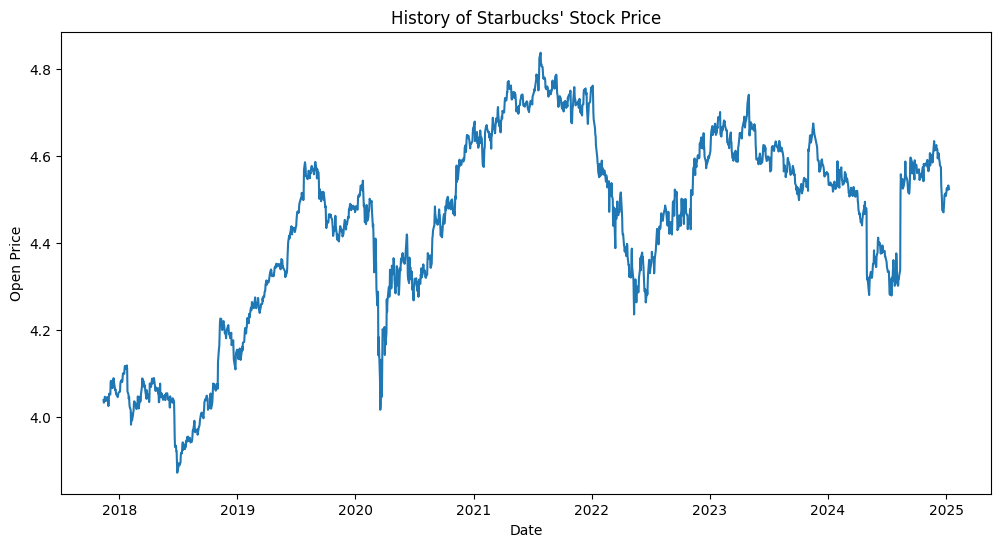

In [50]:
#Visualisation
plt.figure(figsize=(12, 6))
plt.plot(sb_df["Log_Open"])
plt.title("History of Starbucks' Stock Price")
plt.xlabel("Date")
plt.ylabel("Open Price")
plt.show()

In [37]:
#normalising data
# scaler = RobustScaler()
# scaled_data = scaler.fit_transform(sb_df[["Open"]]) ##if i use this scaler method, my MSE and RMSE scores on original prices imrpove, but on scaled it goes down

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sb_df[["Log_Open"]])

#adding time series sequence
def create_sequences(data, seq_length):
  X, Y = [], []
  for i in range(len(data)- seq_length-1):
    X.append(data[i:(i+seq_length), 0])
    Y.append(data[i+seq_length,0])
  return np.array(X), np.array(Y)

seq_length = 60 #last 2 months used for prediction
X, Y = create_sequences(scaled_data, seq_length)

In [38]:
#train, validate and test split
train_size = 0.7
validation_size = 0.15
test_size = 0.15

train_end = int(len(data) * train_size)
val_end = int(len(data)* (train_size + validation_size))

X_train, Y_train = X[:train_end], Y[:train_end]
X_val, Y_val = X[train_end:val_end], Y[train_end:val_end]
X_test, Y_test = X[val_end:], Y[val_end:]

#Reshaping for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print ("Training Data", {X_train.shape}, {Y_train.shape})
print ("Validation Data", {X_val.shape}, {Y_val.shape})
print ("Testing Data", {X_test.shape}, {Y_test.shape})

Training Data {(1260, 60, 1)} {(1260,)}
Validation Data {(270, 60, 1)} {(270,)}
Testing Data {(209, 60, 1)} {(209,)}


In [39]:
#Creating a novel neural network using LSTM layers
def novel_model(seq_length):
  model = Sequential()
  model.add(LSTM(100, activation="relu", return_sequences=True, recurrent_dropout=0.2, input_shape=(seq_length, 1)))
  model.add(Dropout(0.2)) ##started with 0.2, increasing dropout to try narrow the train-test loss gap

  #second layer
  model.add(LSTM(80,activation ="relu")) ##, return_sequences=True i need a seq of output to feed to next layer, hence return seq is True
  model.add(Dropout(0.3))

  # #third layer
  # model.add(LSTM(60, activation="relu")) ##I am not definifing return seq coz I need a single vector for next dense layer- which expecs 2d input
  # model.add(Dropout(0.3)) ##too many layers can possibiliy make training unstable so removing to see if it'll improve performance

  #Dense layers to further compress the output (gradual reduction)
  model.add(Dense(50, activation="relu", kernel_regularizer=l2(0.01))) ##removed regularisation from other layers as that increased the loss - it was excesive regularisation, causing the model to struggle to learn
  model.add(Dense(30, activation="relu"))
  model.add(Dense(15, activation="relu"))

  #output layer
  model.add(Dense(1))
  model.compile(optimizer="adam", loss="mean_squared_error")
  return model

model = novel_model(seq_length)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 60, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 80)                  │          57,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 50)                  │           4,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 30)                  │           1,530 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 15)                  │             465 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              16 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 104,781 (409.30 KB)

 Trainable params: 104,781 (409.30 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
#training
early_stop = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True) ##to prevent overfitting and stopping the model from memorising training data instead of learning general patterns

history= model.fit(X_train, Y_train, epochs=100,
                   batch_size=32, validation_data=(X_val, Y_val),
                   callbacks=[early_stop],
                   verbose=1
                   )

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 179ms/step - loss: 0.7147 - val_loss: 0.3791
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - loss: 0.3355 - val_loss: 0.2149
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - loss: 0.1925 - val_loss: 0.1223
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - loss: 0.1092 - val_loss: 0.0691
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - loss: 0.0624 - val_loss: 0.0376
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - loss: 0.0358 - val_loss: 0.0248
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - loss: 0.0290 - val_loss: 0.0201
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - loss: 0.0187 - val_loss: 0.0145
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - loss: 0.0140 - val_loss: 0.0076
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - loss: 0.0121 - val_loss: 0.0060
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - loss: 0.0090 - val_loss: 0.0053
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━

In [41]:
# # Training history graph
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.legend()
# plt.show()

In [42]:
test_loss = model.evaluate(X_test, Y_test)
train_loss = model.evaluate(X_train, Y_train)
print(f"Test Loss: {test_loss}")
print(f"Train Loss: {train_loss}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0050
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0036
Test Loss: 0.0049237958155572414
Train Loss: 0.003886206541210413


In [43]:
#Evaluating scaled input
Y_pred = model.predict(X_test)
mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2= r2_score(Y_test, Y_pred)

print(f"MAE:{mae:.4f}")
print(f"MSE:{mse:.4f}")
print(f"RMSE:{rmse:.4f}")
print(f"R2 Score:{r2:4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
MAE: 0.0362
MSE:0.0029
RMSE:0.0536
R2 Score:0.754122


In [44]:
##Evaluating actual price predictions
train_predict = model.predict(X_train)
val_predict = model.predict(X_val)
test_predict = model.predict(X_test)

# inversing prediction from vector to actual price
train_predict = scaler.inverse_transform(train_predict)
Y_train_actual = scaler.inverse_transform(Y_train.reshape(-1,1))
val_predict = scaler.inverse_transform(val_predict)
Y_val_actual = scaler.inverse_transform(Y_val.reshape(-1,1))
test_predict = scaler.inverse_transform(test_predict)
Y_test_actual = scaler.inverse_transform(Y_test.reshape(-1,1))

mae_actual= mean_absolute_error(Y_test_actual, test_predict)
mse_actual = mean_squared_error(Y_test_actual, test_predict)
rmse_actual = np.sqrt(mse_actual)

print(f"MAE: {mae_actual:.4f}")
print(f"MSE: {mse_actual:.4f}")
print(f"RMSE: {rmse_actual:.4f}")

# # ##from deepseek
# plt.figure(figsize=(15, 6))
# plt.plot(sb_df.index, sb_df["Log_Open"], label="Actual Price")
# plt.plot(sb_df.index[seq_length:len(train_predict)+seq_length], train_predict, label="Training Predictions")
# plt.plot(sb_df.index[len(train_predict)+seq_length*2+1:len(train_predict)+seq_length*2+len(val_predict)],
#          val_predict, label="Validation Predictions")
# plt.plot(sb_df.index[len(train_predict)+len(val_predict)+seq_length*1:],
#          test_predict, label="Test Predictions")
# plt.legend()
# plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
MAE: 0.0349
MSE: 0.0027
RMSE: 0.0517


In [32]:
#code for actual prediction
def predict_stock(model, last_sequence, future_days):
  predictions = []
  current_sequence = last_sequence.copy() ##making a copy to avoid changing orig

  for i in range(future_days):
    current_input = current_sequence.reshape((1, seq_length,1))
    next_prediction = model.predict(current_input)[0,0]
    predictions.append(next_prediction)

    current_sequence = np.roll(current_sequence,-1)
    current_sequence[-1] = next_prediction
  return scaler.inverse_transform(np.array(predictions).reshape(-1,1))

last_sequence = scaled_data[-seq_length:]
future_predictions = predict_stock(model, last_sequence, 30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━

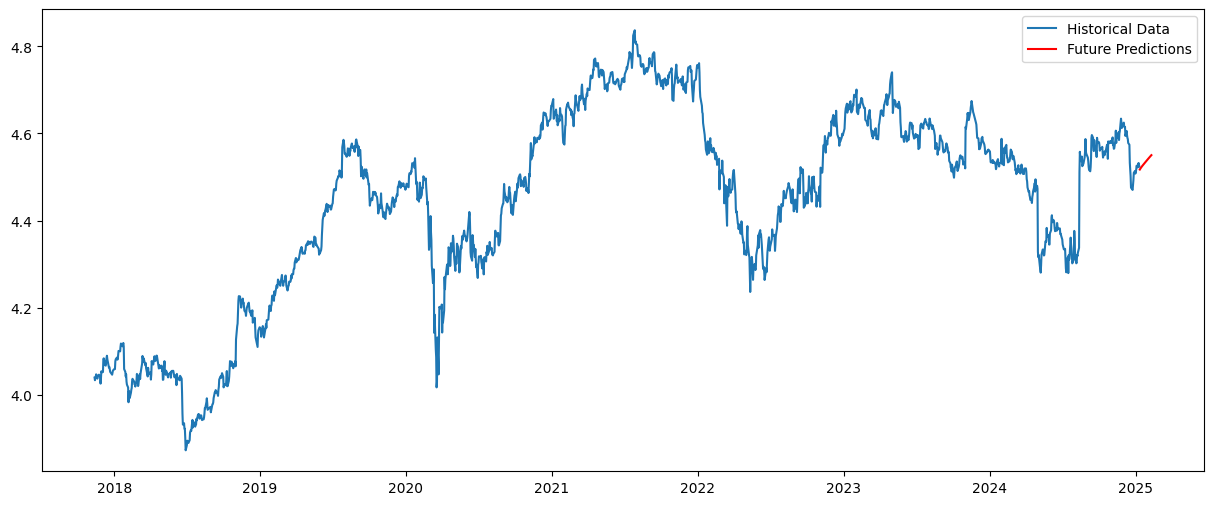

In [33]:
plt.figure(figsize=(15, 6))
plt.plot(sb_df.index, sb_df["Log_Open"], label="Historical Data")
future_dates = pd.date_range(start=sb_df.index[-1], periods=31, freq="D")[1:]
plt.plot(future_dates, future_predictions, "r-", label="Future Predictions")
plt.legend()
plt.show()